# General Notebook on fine-tuning branch point prediction using any of MultiMolecule models

Any RNA model can be selected from the [MultiMolecule](https://multimolecule.danling.org/models/) website. Simple change the `MULTIMOLECULE_MODEL` variable in the cell below, and the the two cells under the tokenizer "Load the desired model and tokenizer" section.

In [1]:
# GLOBAL VARIABLES
WORKING_DIRECTORY = '/content/drive/MyDrive/epfl_ml_project'
DATASET_PATH = 'data/fresh_dataset.txt'
MODEL_MAX_INPUT_SIZE = 1024
MULTIMOLECULE_MODEL = "utrlm-te_el"
SAMPLE_N_DATAPOINTS = 20000 # Sample a small subset of data for testing purposes. Set to None if training on full dataset
SEED = 32

In [2]:
%%capture
!pip install datasets evaluate multimolecule==0.0.5

In [3]:
import pandas as pd
import torch
from transformers import (
     DataCollatorForTokenClassification,
     TrainingArguments,
     Trainer
)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Change working directory to Project folder, you may change this as needed
%cd {WORKING_DIRECTORY}

from BP_LM.scripts.data_preprocessing import *
from BP_LM.scripts.trainer_datasets_creation import *
from BP_LM.scripts.compute_metrics import *

Mounted at /content/drive
/content/drive/MyDrive/epfl_ml_project


## Load the desired model and tokenizer

In [ ]:
# Change this import depending on the model
from multimolecule import RnaTokenizer, UtrLmForTokenPrediction, UtrLmConfig

tokenizer = RnaTokenizer.from_pretrained(f'multimolecule/{MULTIMOLECULE_MODEL}')
# Change line below depending on what model we want

config = UtrLmConfig()
config.problem_type = "single_label_classification"
config.num_labels = 2
model = UtrLmForTokenPrediction.from_pretrained(f'multimolecule/{MULTIMOLECULE_MODEL}', config=config)

Some weights of UtrLmForTokenPrediction were not initialized from the model checkpoint at multimolecule/utrlm-te_el and are newly initialized: ['token_head.decoder.bias', 'token_head.decoder.weight', 'utrlm.pooler.dense.bias', 'utrlm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Set up the collator
data_collator = DataCollatorForTokenClassification(tokenizer)

## Create dataset objects for training

In [ ]:
# Load dataset
df = pd.read_csv(DATASET_PATH, sep='\t')

train_dataset, val_dataset, test_dataset = create_dataset(df, tokenizer, model, MODEL_MAX_INPUT_SIZE, SEED, SAMPLE_N_DATAPOINTS)

Chromosomes in train set: {'chr6', 'chr2', 'chr16', 'chr13', 'chr21', 'chr3', 'chr18', 'chr7', 'chr5', 'chr15', 'chrY', 'chr17', 'chr12', 'chr19', 'chrX', 'chr20', 'chr4', 'chr22', 'chr14', 'chr1'}
Chromosomes in validation set: {'chr9', 'chr10'}
Chromosomes in test set: {'chr8', 'chr11'}

Total data points: 20000
Train set contains 16579 data points (82.89%)
Validation set contains 1582 data points (7.91%)
Test set contains 1839 data points (9.20%)


## Train model

In [ ]:
# Do not save to W&B
import os
os.environ["WANDB_MODE"] = "disabled"

In [ ]:
# Define model training parameters
batch_size = 16

args = TrainingArguments(
    f"multimolecule-{MULTIMOLECULE_MODEL}-finetuned-secondary-structure",
    eval_strategy="steps",
    eval_steps=1000,
    save_strategy="steps",
    save_steps=10000,
    learning_rate=3e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    optim = "adamw_torch",
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="F1",
    #eval_accumulation_steps = 10,
    #push_to_hub=True,
)

<ipython-input-25-7160a7d960c2>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,F1,Seq. acc.,Ap,Mcc,Auc,Ideal Threshold
2000,0.002200,0.001797,0.724543,0.654235,0.791139,0.724202,0.850365,0.493417


TrainOutput(global_step=3111, training_loss=0.0044092493295209735, metrics={'train_runtime': 804.9362, 'train_samples_per_second': 61.79, 'train_steps_per_second': 3.865, 'total_flos': 369455719311576.0, 'train_loss': 0.0044092493295209735, 'epoch': 3.0})

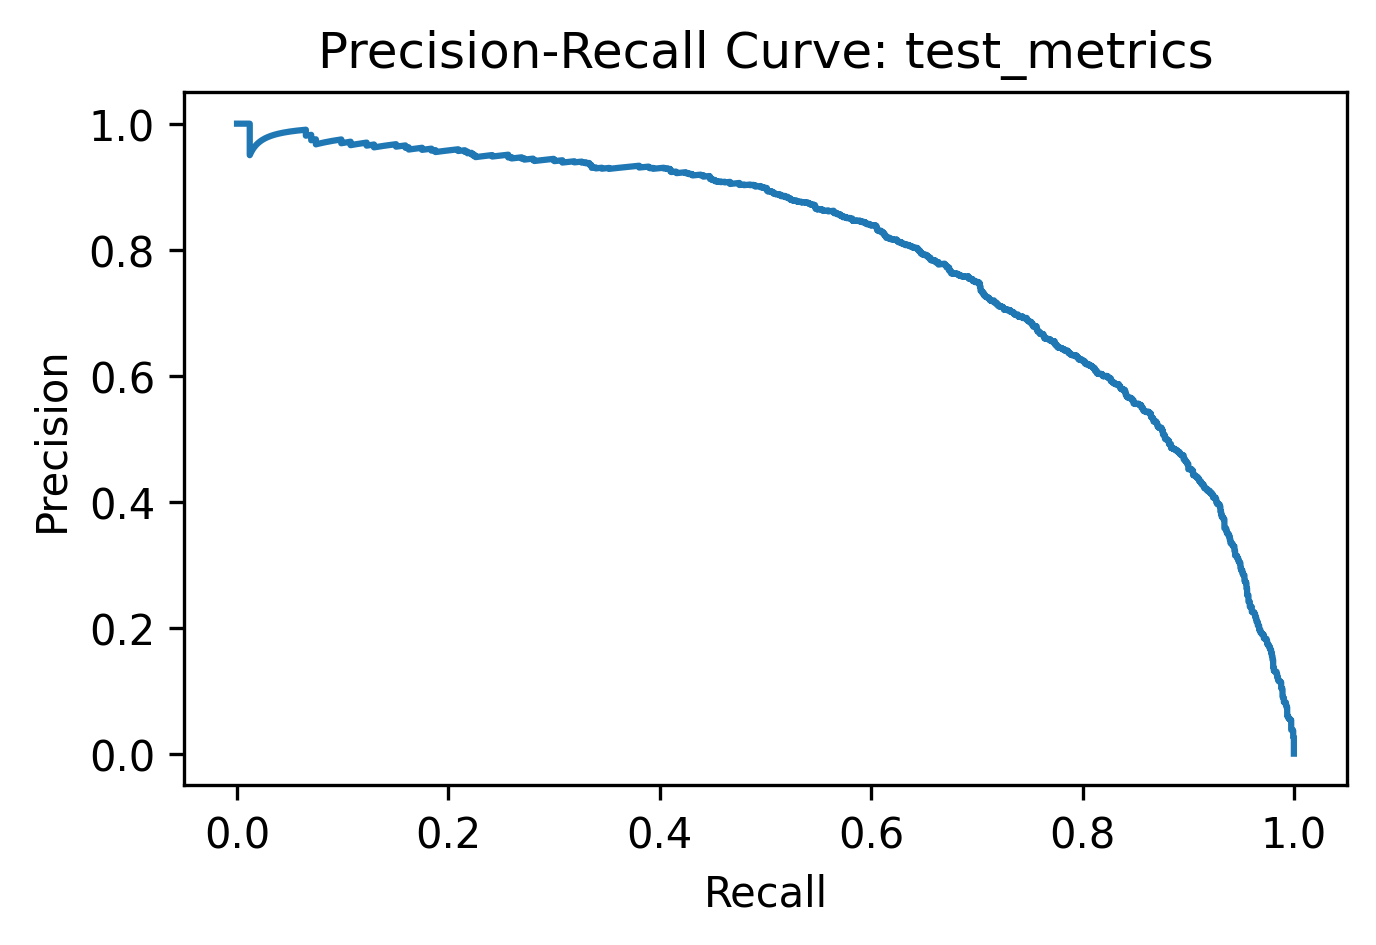

In [ ]:
metrics = lambda x: compute_metrics(x, "test_metrics")
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()


In [ ]:
trained_model = AutoModelForTokenClassification.from_pretrained(f"multimolecule-{MULTIMOLECULE_MODEL}-finetuned-secondary-structure/checkpoint-777") #make sure you are loading the right checkpoint
tokenizer = AutoTokenizer.from_pretrained(f"multimolecule-{MULTIMOLECULE_MODEL}-finetuned-secondary-structure/checkpoint-777")
data_collator = DataCollatorForTokenClassification(tokenizer)

OSError: multimolecule-utrlm-te_el-finetuned-secondary-structure/checkpoint-777 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [ ]:
metric = lambda x: compute_metrics_test(x, "test_metrics", 0.001895)

testing_args = TrainingArguments(
    output_dir='/results',
    per_device_eval_batch_size=batch_size,
    do_eval=True,
    no_cuda=False,
)

tester = Trainer(
    model=trained_model,
    args=testing_args,
    eval_dataset=test_dataset,
    compute_metrics=metric,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

metrics = tester.evaluate()

print("Evaluation Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value}")